<a href="https://colab.research.google.com/github/artsasse/fedkan/blob/main/Flower_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Federated MLP to classify MNIST

This notebook is based mainly on the Flower Tutorial "Use a federated learning strategy", found in https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html .

## Global Values

In [38]:
NUM_PARTITIONS = 100
BATCH_SIZE = 100
LOCAL_EPOCHS = 1
FRACTION_CLIENTS = 0.1
COMM_ROUNDS = 3
SEED = 1

## Dependencies

In [3]:
pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.4/464.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [78]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import random
import os
from logging import INFO

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, SimpleClientManager
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation, start_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

from kan import KAN

# Preciso alterar o runtime para usar GPU (SASSE)
# DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
DEVICE = torch.device("cpu")  # Run training on CPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.11.0 / PyTorch 2.4.0+cu121


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data loading

In [72]:
def load_datasets(partition_id: int, num_partitions: int):

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)),
         transforms.Lambda(lambda x: torch.flatten(x))  # Flatten the image into a 1D tensor
         ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    # def seed_worker(worker_id):
    #   worker_seed = torch.initial_seed() % 2**32
    #   np.random.seed(worker_seed)
    #   random.seed(worker_seed)

    # g = torch.Generator()
    # g.manual_seed(SEED)

    fds = FederatedDataset(dataset="mnist", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id).with_transform(apply_transforms)
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True,
                            #  worker_init_fn=seed_worker, generator=g
                             )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                            # worker_init_fn=seed_worker, generator=g
                            )

    return trainloader, testloader

## Model training/evaluation (PyTorch)

In [6]:
class Net(nn.Module):

    def __init__(self) -> None:
        super(Net, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 200)  # 28 x 28 pixels
        self.layer2 = nn.Linear(200, 200)  # 2 hidden layers with 200 neurons each
        self.layer3 = nn.Linear(200, 10)  # 10 classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

# class Net(KAN):
#     def __init__(self) -> None:
#         super().__init__([28 * 28, 24, 24, 10])


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Flower Architecture

### Flower client

In [7]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader=None):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader).to_client()

### Server-side parameter **evaluation**

#### Save evaluation results

In [41]:
history = {"accuracy": [], "loss": []}
def save_history(server_round: int, accuracy: float, loss: float):
    history["accuracy"].append((accuracy, server_round))
    history["loss"].append((loss, server_round))

#### Evaluation function

In [42]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    save_history(server_round, accuracy, loss)
    return loss, {"accuracy": accuracy}

### Training **Configuration** (e.g. epochs)




In [43]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config

### Flower **Server**

#### Client Manager with Reproducible Sampling

In [106]:
def reproducible_sample(available_cids, num_clients):
    return random.sample(available_cids, num_clients)

class ReproducibleClientManager(SimpleClientManager):
    # Override sample method
    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
        criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:
        """Sample a number of Flower ClientProxy instances."""
        # Block until at least num_clients are connected.
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]

        if num_clients > len(available_cids):
            log(
                INFO,
                "Sampling failed: number of available clients"
                " (%s) is less than number of requested clients (%s).",
                len(available_cids),
                num_clients,
            )
            return []

        sampled_cids = reproducible_sample(available_cids, num_clients)
        return [self.clients[cid] for cid in sampled_cids]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=FRACTION_CLIENTS,
        fraction_evaluate=0,
        min_fit_clients=1,
        min_evaluate_clients=0,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,  # Pass the fit_config function
    )

    # Create ClientManager with reproducible sampling
    client_manager = ReproducibleClientManager()

    config = ServerConfig(num_rounds=COMM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config, client_manager=client_manager)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Simulation

### Seed and Reproducibility Setup

In [116]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Global model **initialization**

In [117]:
# Create an instance of the model and get the parameters
initial_model = Net()
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 199210


### Run Simulation 1

In [115]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.5, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# Define new history
history = {"accuracy": [], "loss": []}

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      initial parameters (loss, other metrics): 0.0230280880689621, {'accuracy': 0.112}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0230280880689621 / accuracy 0.112


(pid=38528) 2024-08-30 20:06:47.545751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=38528) 2024-08-30 20:06:47.570625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=38528) 2024-08-30 20:06:47.577806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=38528) 2024-08-30 20:06:49.080743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=38528) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor 

(ClientAppActor pid=38528) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.023014912381768227, accuracy 0.11666666666666667
(ClientAppActor pid=38528) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.023013418540358543, accuracy 0.135
(ClientAppActor pid=38528) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.023015806451439857, accuracy 0.13666666666666666
(ClientAppActor pid=38528) [Client 35, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.0230153426527977, accuracy 0.145
(ClientAppActor pid=38528) [Client 63, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.023020150139927864, accuracy 0.11333333333333333
(ClientAppActor pid=38528) [Client 87, roun

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.022988128733634948, {'accuracy': 0.2526}, 32.29985429200042)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.022988128733634948 / accuracy 0.2526
(ClientAppActor pid=38528) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022978387773036957, accuracy 0.24
(ClientAppActor pid=38528) [Client 33, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022978832945227623, accuracy 0.285
(ClientAppActor pid=38528) [Client 38, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.02298007905483246, accuracy 0.215
(ClientAppActor pid=38528) [Client 78, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.02296648733317852, accuracy 0.245
(ClientAppActor pid=38528) [Client 83, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022979123517870903, accuracy 0.27666666666666667
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=38528) Epoch 1: train loss 0.02297123149037361, accuracy 0.24666666666666667


INFO :      fit progress: (2, 0.022946128034591676, {'accuracy': 0.2047}, 54.64729144500052)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.022946128034591676 / accuracy 0.2047
(ClientAppActor pid=38528) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022936508059501648, accuracy 0.245
(ClientAppActor pid=38528) [Client 31, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022927330806851387, accuracy 0.20833333333333334
(ClientAppActor pid=38528) [Client 47, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022926492616534233, accuracy 0.17833333333333334
(ClientAppActor pid=38528) [Client 79, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.022932199761271477, accuracy 0.21166666666666667
(ClientAppActor pid=38528) [Client 90, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=38528) Epoch 1: train loss 0.0229235

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=38528) Epoch 1: train loss 0.022926924750208855, accuracy 0.2


INFO :      fit progress: (3, 0.022889632272720336, {'accuracy': 0.1706}, 79.27390379000008)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 79.28s
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0230280880689621
INFO :      		round 1: 0.022988128733634948
INFO :      		round 2: 0.022946128034591676
INFO :      		round 3: 0.022889632272720336
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.112), (1, 0.2526), (2, 0.2047), (3, 0.1706)]}
INFO :      


Server-side evaluation loss 0.022889632272720336 / accuracy 0.1706


## Run Simulation 2

In [118]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.5, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# Define new history
history = {"accuracy": [], "loss": []}

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      initial parameters (loss, other metrics): 0.0230280880689621, {'accuracy': 0.112}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.0230280880689621 / accuracy 0.112


(pid=39547) 2024-08-30 20:08:51.256957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=39547) 2024-08-30 20:08:51.284413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=39547) 2024-08-30 20:08:51.291478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=39547) 2024-08-30 20:08:52.850674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=39547) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor 

(ClientAppActor pid=39547) [Client 17, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.02301565557718277, accuracy 0.135
(ClientAppActor pid=39547) [Client 27, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.023016273975372314, accuracy 0.13
(ClientAppActor pid=39547) [Client 45, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.023017577826976776, accuracy 0.11333333333333333
(ClientAppActor pid=39547) [Client 54, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.023009736090898514, accuracy 0.14166666666666666
(ClientAppActor pid=39547) [Client 58, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.023017939180135727, accuracy 0.12666666666666668
(ClientAppActor pid=39547) [Client 78, r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.022987152314186098, {'accuracy': 0.212}, 30.20344212800046)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.022987152314186098 / accuracy 0.212
(ClientAppActor pid=39547) [Client 15, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022977393120527267, accuracy 0.18833333333333332
(ClientAppActor pid=39547) [Client 25, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022972896695137024, accuracy 0.19333333333333333
(ClientAppActor pid=39547) [Client 45, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022969214245676994, accuracy 0.2
(ClientAppActor pid=39547) [Client 46, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022972840815782547, accuracy 0.235
(ClientAppActor pid=39547) [Client 81, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.02297542616724968, accu

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=39547) Epoch 1: train loss 0.02296130172908306, accuracy 0.195


INFO :      fit progress: (2, 0.02294366555213928, {'accuracy': 0.154}, 50.30459433500073)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02294366555213928 / accuracy 0.154
(ClientAppActor pid=39547) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.02293422631919384, accuracy 0.15333333333333332
(ClientAppActor pid=39547) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022915786132216454, accuracy 0.145
(ClientAppActor pid=39547) [Client 11, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022913066670298576, accuracy 0.165
(ClientAppActor pid=39547) [Client 30, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022936008870601654, accuracy 0.15
(ClientAppActor pid=39547) [Client 34, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=39547) Epoch 1: train loss 0.022935522720217705, accuracy 0.143333333

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.022882481694221496, {'accuracy': 0.1391}, 69.63257552800133)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 69.64s
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0230280880689621
INFO :      		round 1: 0.022987152314186098
INFO :      		round 2: 0.02294366555213928
INFO :      		round 3: 0.022882481694221496
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.112), (1, 0.212), (2, 0.154), (3, 0.1391)]}
INFO :      


Server-side evaluation loss 0.022882481694221496 / accuracy 0.1391


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

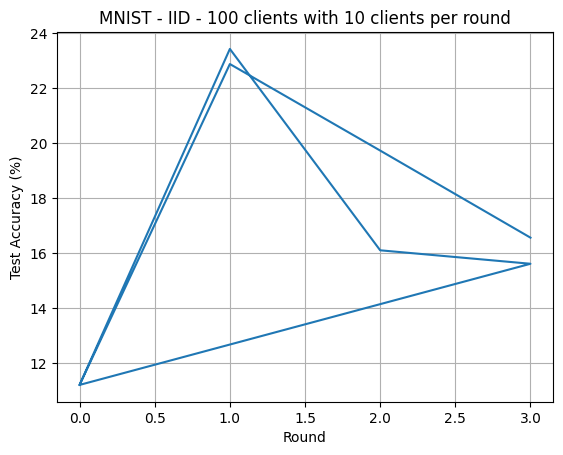

In [50]:
global_accuracy_centralised = history["accuracy"]
round = [data[1] for data in global_accuracy_centralised]
acc = [100.0 * data[0] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Test Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

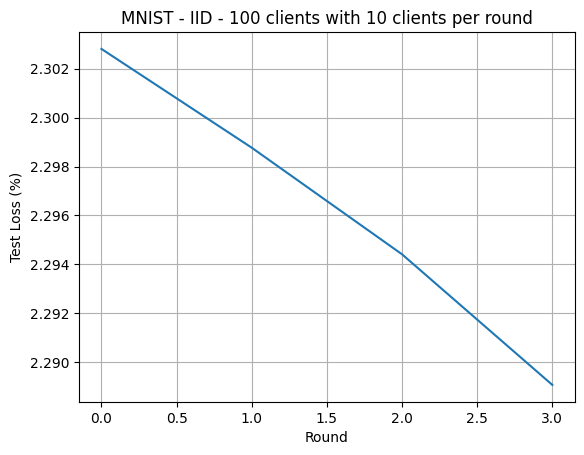

In [46]:
global_loss_centralised = history["loss"]
round = [data[1] for data in global_loss_centralised]
loss = [100.0 * data[0] for data in global_loss_centralised]
plt.plot(round, loss)
plt.grid()
plt.ylabel("Test Loss (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

In [47]:
history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': [(0.112, 0), (0.2343, 1), (0.161, 2), (0.1561, 3)],
 'loss': [(0.0230280880689621, 0),
  (0.02298769462108612, 1),
  (0.02294411289691925, 2),
  (0.022890711307525635, 3)]}